In [1]:
%load_ext autoreload
%autoreload 2

# Assessing Multicollinearity | All Variables

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, prepare_data, get_pi_matrix, get_condition_number

import matplotlib
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from collections import Counter
from scipy.stats import f
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

plt.rc('font',family = 'serif')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = 1

DB5.insert(loc=2,column="label_9998",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = 1

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


In [4]:
plasma_characteristics = ["Q95","BEIMHD","PREMAG",
                          "CONFIG","DWDIA","WMHD","TORQ","KAREA", "EPS","MEFF","VOL","LCOULOMB",
                          "IP","RHOSTAR","NUSTAR","BETASTAR"] 
TOK_characteristics = ["TOK","WALMAT","DIVMAT","LIMMAT","AMIN","BT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ECHMODE","PELLET"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI","PNBI"]
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 

features = plasma_characteristics + TOK_characteristics + ELM + \
           heating + impurities + power + temperatures + fast_particles

num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()

```Python
>>> print(sorted(features))

['AMIN', 'AUXHEAT', 'BEIMHD', 'BETASTAR', 'BT', 'CONFIG', 'DIVMAT', 'DWDIA', 'ECHMODE', 'ELMFREQ', 'ELMTYPE', 'ENBI', 'EPS', 'EVAP', 'ICSCHEME', 'IP', 'KAREA', 'LCOULOMB', 'LIMMAT', 'MEFF', 'NEL', 'NESOL', 'NUSTAR', 'OMEGACYCL', 'PECRH', 'PELLET', 'PFLOSS', 'PICRH', 'PLTH', 'PNBI', 'POHM', 'PRAD', 'PREMAG', 'Q95', 'RHOSTAR', 'TAV', 'TEV', 'TIV', 'TOK', 'TORQ', 'VOL', 'WALMAT', 'WFFORM', 'WFICFORM', 'WMHD', 'ZEFF', 'ZEFFNEO']

```

### OLD SUBSET WITH GOOD PERFORMANCE IN RF

```Python
# MAX VIF ~ 4.5 with "RHOSTAR" | With old code

features = ['AUXHEAT','BETASTAR','BT','DIVNAME','ECHMODE','ELMFREQ','ELMTYPE',
            'ENBI','HYBRID','IP','KAREA','LHTIME','MEFF','NUSTAR','PECRH',
            'PELLET','PNBI','POHM','PREMAG','Q95','RHOSTAR',
            'TAV','TEV','TORQ','WFFORM','ZEFFNEO']

# n_estimators = 93, max_depth=20
(array([0.89095745, 0.94471659]),
 array([0.80917874, 0.9705248 ]),
 array([0.84810127, 0.95744681]),
 array([ 414, 1391]))
# Most important features: ['RHOSTAR', 'TAV', 'NUSTAR', 'LHTIME', 'BETASTAR'] | Impurity
# Most important features: ['RHOSTAR', 'TAV', 'LHTIME', 'BETASTAR', 'NUSTAR'] | Permutation

```

# Updated Analysis | Results

```Python
features = ['AUXHEAT', 'BEIMHD', 'BETASTAR', 'BT', 'CONFIG', 'DIVMAT', 'DWDIA', 'ECHMODE', 
            'ELMFREQ', 'ELMTYPE', 'EVAP', 'ICSCHEME', 'IP', 
            'LIMMAT', 'NEL', 'NESOL', 'NUSTAR', 'PECRH', 'PELLET', 'PFLOSS', 
            'PICRH', 'POHM', 'PRAD', 'PREMAG', 'Q95', 'RHOSTAR', 
            'TIV', 'TOK', 'TORQ', 'WALMAT', 'WFFORM', 'WFICFORM', 'ZEFF', 'ZEFFNEO']

# All features condition number: 404.89256324590554
# After removing PLTH, AMIN, and LCOULOMB; condition number: 67.44506605351036
# After removing previous + KAREA, EPS, MEFF; condition number: 28.065937093415247

# Removed: PLTH, AMIN, LCOULOMB, KAREA, EPS, MEFF, TAV, ENBI, PNBI, OMEGACYCL, TEV, VOL, WMHD
# Resultant condition number: 13.07. 

# PLTH, 4200
# AMIN, 1600
# LCOULOMB, 600
# KAREA, 180
# EPS, 110
# MEFF, 70
# TAV, 31
# ENBI, 29
# PNBI, 26
# OMEGACYCL, 23
# TEV, 19
# VOL, 16
# WMHD, 14
```

In [174]:
features = ['AUXHEAT','BETASTAR','BT','DIVNAME','ECHMODE','ELMFREQ','ELMTYPE',
            'ENBI','HYBRID','IP','KAREA','LHTIME','MEFF','NUSTAR','PECRH',
            'PELLET','PNBI','POHM','PREMAG','Q95','RHOSTAR',
            'TAV','TEV','TORQ','WFFORM','ZEFFNEO']

# See functions inside `tokamakTK`

In [175]:
DB5 = tokamakTK.clean_categorical_data(DB5)

# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()

data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num, SS_scaling=False, UL_scale=True)
#data = pd.concat([data_cat, data_num], axis=1)

In [176]:
Π = get_pi_matrix(data_num, num_features, scale=False, intercept=False)

Condition Number: 34.72557059305996


Condition Index
[  1.    49.54  61.23  79.27  87.95  98.46 105.62 114.46 126.21 133.35
 155.88 180.47 184.22 254.62 334.16 375.83 397.98 421.5  661.45 961.03]


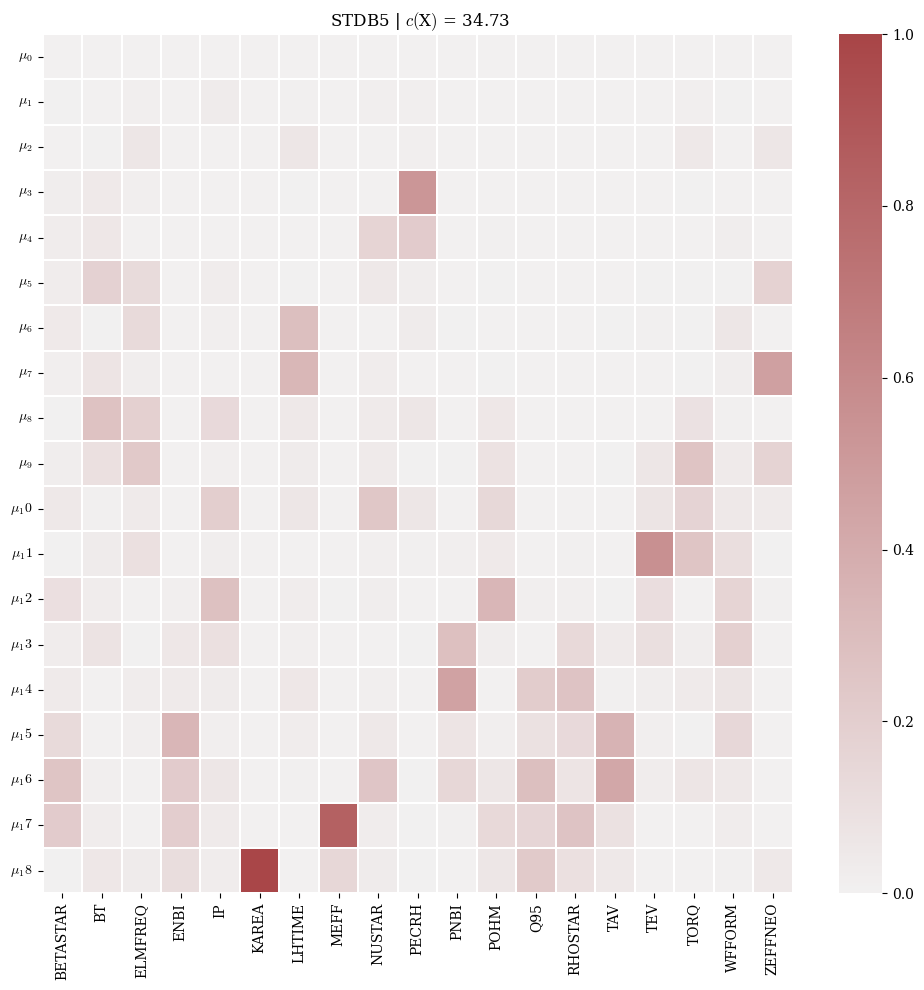

In [177]:
print("Condition Index")
print(f"{np.round(tokamakTK.get_condition_index(data_num),2)}")
# Create the figure and subplots
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

# Plotting subplot 1
sns.heatmap(Π, vmin=0, vmax=1,  linecolor="white", linewidth=0.1, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f" STDB5 | $c($X$)$ = {round(get_condition_number(data_num),2)}")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Adjust the layout and spacing between subplots
plt.tight_layout()
#plt.savefig(fig_path+"VD_STDB599.pdf", format="pdf", dpi=800, bbox_inches='tight');

## Variance Inflation Factor (VIF) and Tolerance

The Variation Inflation Factor (VIF) is a measure of multicollinearity in a linear regression model. It quantifies the degree to which the variance of the estimated regression coefficient is inflated due to collinearity in the predictors.

"One recommendation is that **if VIF is greater than 5**, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this." [[statsmodels]](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

$$
    \text{VIF}_j = \frac{1}{1-R^2_j}.
$$

With $R^2_j$ being the coefficient of determination for the regression of $x_j$ on the remaining variables; namely, 

$$
    R^2 = 1 - \frac{RSS}{TSS}.
$$

With $RSS$ being the sum of squares of residuals; and, $TSS$ the total sum of squares;

$$
    SSR = \sum_i\left( \hat{y} - \bar{y} \right)^2; \quad \text{and} \quad TSS = \sum_i\left( y - \bar{y} \right)^2
$$

**Tolerance** is the inverse of VIF and relates to the proportion of variance in a predictor variable. A **tolerance value less than 0.1** is generally considered to be indicative of problematic multicollinearity.|

In [178]:
VIF = pd.DataFrame()
VIF["STDB5"]=[variance_inflation_factor(data_num.values, f) for f in range(len(data_num.columns))]
VIF.index = data_num.columns

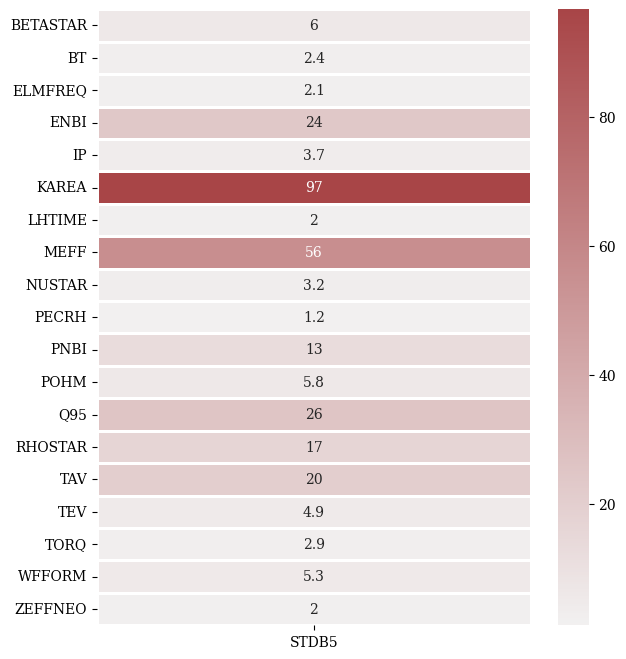

In [179]:
plt.figure(figsize=(7,8))
ax = sns.heatmap(VIF, annot=True,
                 cmap=sns.color_palette("light:#A84547", as_cmap=True), linecolor="white", linewidth=0.73)
#plt.savefig(fig_path+"VIF_all_datasets_noIP.pdf", format="pdf", dpi=800, bbox_inches='tight');